In [50]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from scipy import signal
from sklearn.metrics import mean_squared_error
import seaborn as sns 
import matplotlib.pyplot as plt
"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

In [62]:
11993/258

46.48449612403101

In [2]:
device = 'cuda'

## Create a Torch.Dataset class for the training dataset

In [3]:
from glob import glob
import pickle5
import numpy as np

ROOT_PATH = "C:/Users/Administrator/cse151b-spring2022/argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle5.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    resampled = []
    for i in inputs:
        resampled.append(signal.resample(i, 60))

    resampled = np.array(resampled)
    #print(resampled.shape)
    outputs = None
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle5.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

        return torch.from_numpy(resampled).float(), torch.from_numpy(outputs).float()

    if split=="test":
    
        return torch.from_numpy(resampled).float(), torch.from_numpy(np.array([]))

def transform(tup):

    return (signal.resample(tup[0], 60), tup[1])

    

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None, device='cpu'):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform
        self.split = split
        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)
        self.inputs = self.inputs.to(device)
        self.outputs = self.outputs.to(device)
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        if self.split == 'train':
            data = (self.inputs[idx], self.outputs[idx])
        if self.split == 'test':
            data = self.inputs[idx]
            
        if self.transform:
            #data[0] = self.transform(data[0])
            data = self.transform(data)

        return data

# intialize a dataset
city = 'palo-alto' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split, device=device)

## Create a DataLoader class for training

In [4]:
batch_sz = 256  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz)

In [5]:
test_dataset = ArgoverseDataset(city=city, split='test', device=device)
test_loader = DataLoader(test_dataset,batch_size=batch_sz)

# LSTM

In [65]:
epochs = 1000
hidden_size = 2
lr = 0.5

In [66]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

    def forward(self, input):
        #h0 = torch.zeros(1, input.size(0), self.hidden_size).float().to(device)
        #c0 = torch.zeros(1, input.size(0), self.hidden_size).float().to(device)
        
        out, hid = self.lstm(input)
        return out, hid

    # def initHidden(self):
    #     return torch.zeros(1, 1, self.hidden_size, device=device)


In [67]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

        

    def forward(self, input, hidden):
        output, hidden = self.lstm(input, hidden)
        output = self.out(output)
        #output = self.softmax(output)
        return output, hidden

    # def init_state(self, encoded):
    #     #torch.zeros(1, 1, self.hidden_size, device=device)
    #     return encoded[1]


In [68]:
encoder = EncoderRNN(input_size=2, hidden_size=hidden_size)
decoder = DecoderRNN(hidden_size=hidden_size, output_size=2)
encoder.to(device)
decoder.to(device)
optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)

In [69]:
criterion = nn.MSELoss()
losses = []
for epoch in range(epochs):
    for x, y in train_loader:
        #print(f'input x shape: {x.shape}')
        #print(f'input y shape: {y.shape}')
        encoder.train()
        optimizer.zero_grad()
        encoded, hid = encoder(x)
        #print(f'encoded shape: {encoded.shape}')
        outputs, hid = decoder(encoded, hid)
        #print(f'decoded shape: {outputs.shape}')
        train_loss = criterion(outputs, y)
        #print(outputs)
        train_loss.backward()
        optimizer.step()

    losses.append(float(train_loss.item()))    
    if epoch % 10 == 0:
        print(f'epoch {epoch}, loss: {train_loss.item()}')

epoch 0, loss: 2270717.75
epoch 10, loss: 2270680.75


KeyboardInterrupt: 

In [64]:
470

470

<AxesSubplot:>

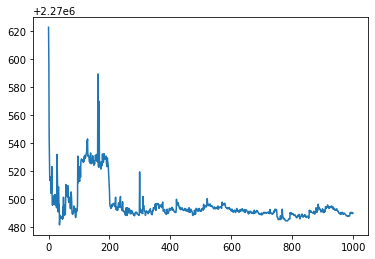

In [60]:
sns.lineplot(y = losses, x = range(epochs))
plt.savefig

In [49]:
preds = torch.tensor([])
for x in test_loader:
    encoder.eval()
    decoder.eval()

    encoded, hid = encoder(x)
    outputs, hid = decoder(encoded, hid)
    outputs = outputs.to('cpu').detach()
    preds = torch.cat((preds, outputs), dim=0)
    #preds.append(outputs)    

In [20]:
preds

tensor([[[ 0.6454,  3.0056],
         [ 0.8559,  3.2777],
         [ 0.9465,  3.3650],
         ...,
         [ 0.5702,  1.8195],
         [ 0.5701,  1.8195],
         [ 0.5701,  1.8195]],

        [[ 1.7356,  2.6075],
         [ 1.9702,  2.8681],
         [ 2.0568,  2.9258],
         ...,
         [ 1.2075,  1.5235],
         [ 1.2075,  1.5236],
         [ 1.2074,  1.5235]],

        [[-1.1428,  2.7447],
         [-1.2801,  2.9393],
         [-1.4046,  3.0269],
         ...,
         [-0.8767,  1.5261],
         [-0.8767,  1.5261],
         [-0.8767,  1.5261]],

        ...,

        [[-1.4716,  2.4451],
         [-1.6381,  2.6373],
         [-1.7716,  2.7200],
         ...,
         [-1.0736,  1.4172],
         [-1.0679,  1.4167],
         [-1.0735,  1.4172]],

        [[ 1.6303,  2.6880],
         [ 1.8571,  2.9559],
         [ 1.9617,  3.0141],
         ...,
         [ 1.1662,  1.5476],
         [ 1.1662,  1.5476],
         [ 1.1662,  1.5476]],

        [[-0.1087,  3.2074],
       

## Sample a batch of data and visualize 

In [13]:
# import matplotlib.pyplot as plt
# import random


# def show_sample_batch(sample_batch):
#     """visualize the trajectory for a batch of samples"""
#     inp, out = sample_batch
#     batch_sz = inp.size(0)
#     agent_sz = inp.size(1)
    
#     fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
#     fig.subplots_adjust(hspace = .5, wspace=.001)
#     axs = axs.ravel()   
#     for i in range(batch_sz):
#         axs[i].xaxis.set_ticks([])
#         axs[i].yaxis.set_ticks([])
        
#         # first two feature dimensions are (x,y) positions
#         axs[i].scatter(inp[i,:,0], inp[i,:,1])
#         axs[i].scatter(out[i,:,0], out[i,:,1])

        
# for i_batch, sample_batch in enumerate(train_loader):
#     inp, out = sample_batch
#     """
#     TODO:
#       implement your Deep learning model
#       implement training routine
#     """
#     show_sample_batch(sample_batch)
#     break